# Setup and Imports

Import all necessary packages and modules.

In [1]:
import sys
sys.path.insert(0,'../..')  # add project root to PATH

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# supress tensorflow depreciation warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

C:\Users\1luka\anaconda3\envs\sa_exercise_05\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import cv2
import time
import numpy as np

In [5]:
# imports
from src.annotated_image import Image
from src.model import TinyYoloV3
from src.model_utils import yolo_eval

Using TensorFlow backend.


In [14]:
model_path = '../../models/custom_trained_weights/model_1308_custom_jittering.h5'
# set these two variables for selecting the inference mode
using_nano_camera = True
detect_on_space_keystroke = True

# Object Detection

Instantiate the object detector and perform some detections for demonstration.

In [15]:
model = TinyYoloV3(path=model_path)

In [16]:
def load_and_detect(model, image_path, rescale=False):
    image = Image(path=image_path)
    if rescale:
        image.resize(*model.config.input_size)
    img_box = model.detect(image)
    
    return img_box

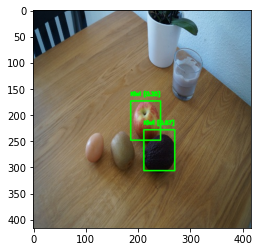

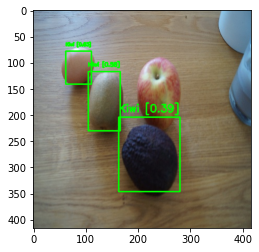

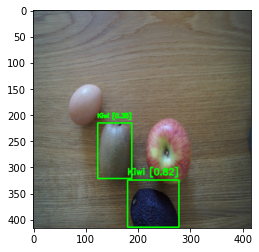

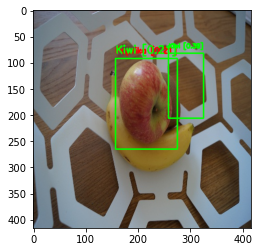

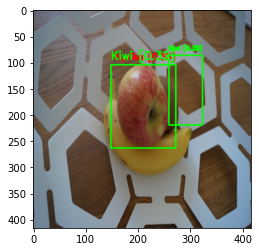

In [19]:
test_image_paths = [f"../../data/ail_00{i}_kiw.jpg" for i in range(1, 6)]
for image in test_image_paths:
    load_and_detect(model, image)

# Paprika-Detector: Webcam/Jetson Nano

The following code sections describe the deployment of our model on the Jetson NANO or via webcam. The relevant settings and parameters will be selected based on the variables `using_nano_camera` and `detect_on_space_keystroke` as set at the beginning of this notebook.

In [ ]:
# setup the streamer pipeline for accessing the NANO camera
def gstreamer_pipeline(
    capture_width=1280,
    capture_height=720,
    display_width=1280,
    display_height=720,
    framerate=60,
    flip_method=0,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (
            capture_width,
            capture_height,
            framerate,
            flip_method,
            display_width,
            display_height,
        )
    )

In [ ]:
# setup the different streams conditional on which camera should be used
if using_nano_camera:
    print("Using nano camera")
    cap = cv2.VideoCapture(gstreamer_pipeline(flip_method=0, 
                                          capture_width=int(3264),
                                          capture_height=int(2464),
                                          display_width=1200,
                                          display_height=800,
                                          framerate=10), cv2.CAP_GSTREAMER)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1200)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 800)
else:
    print("Using webcam")
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1024)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 768)

In [ ]:
def load_and_detect_live(model, image, rescale=False):
    """
    This function performs live detection via webcam or NANO cam. 
    
    Parameters
    ----------
        model: keras model
            instance of the predictive model (in our case TinyYoloV3)
        image: Image
            image to perform detection on
            
            
    Returns
    -------
        img_box: Image
            annotated image with bounding boxes
    """
    
    if rescale:
        image.resize(*model.config.input_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # perform detection and calculcate frame rate
    print("Detection Triggered!")
    start = time.time()
    img_box = model.detect(image)
    end = time.time()
    delta = end - start
    print("Frame Rate in fps: ", (1/delta))
    print("Detection Completed!")
    img_box = img_box.apply_annotations_to_image(model.config.class_colors)
    img_box = cv2.cvtColor(img_box.image_data, cv2.COLOR_RGB2BGR)
    
    return img_box

In [ ]:
def show_camera(video_cap):
    """
    This function is executing the Paprika-Detektor on webcam video data.
    
    Parameters
    ----------
        video_cap: VideoCapture
            instance of video streamer
        inference_pipeline: function
            if applicable image preprocessing can be done via this pipeline
            
    Returns
    -------
        none
    
    """
    
    if cap.isOpened():
        current_frame = 0
        while(True):
            try:
                ret, img = cap.read()
            except:
                print('Open Error! Resuming with next frame.')
                continue
            else:
                if current_frame % 5 == 0:
                    img = load_and_detect_live(model, img)
                    cv2.imshow('Webcam-Detector', img)
                    # end streaming on ESC
                    keyCode = cv2.waitKey(30) & 0xFF
                    if keyCode == 27:
                        break
                current_frame = current_frame + 1
        cap.release()
        cv2.destroyAllWindows()
    else:
        print("Unable to open camera!")

In [ ]:
def show_camera_keystroke(video_cap):
    """
    This function is executing the Paprika-Detektor on webcam video data. 
    Detection is triggered and released by keystrokes.
    
    Parameters
    ----------
        video_cap: VideoCapture
            instance of video streamer
        inference_pipeline: function
            if applicable image preprocessing can be done via this pipeline
            
    Returns
    -------
        none
    
    """
    
    if cap.isOpened():
        while(True):
            try:
                ret, img = cap.read()
            except:
                print('Open Error! Resuming with next frame.')
                continue
            else:
                cv2.imshow('Webcam-Detector', img)
                # end streaming on ESC
                keyCode = cv2.waitKey(30) & 0xFF
                if keyCode == 27:
                    break
                # perform detection on space key
                if keyCode == 32:
                    img = load_and_detect_live(model, img)
                    cv2.imshow('Webcam-Detector', img)
                    keyCode = cv2.waitKey(0) & 0xFF
                    if keyCode == 32:
                        continue
        cap.release()
        cv2.destroyAllWindows()
    else:
        print("Unable to open camera!")

In [ ]:
# call this function to start the stream
if detect_on_space_keystroke:
    show_camera_keystroke(cap)
else:
    show_camera(cap)

### Detection using TensorRT

The following code snippets will perform detection using the converted TensorRT model. Optimization of the model has already been done in another notebook. We will read the optimized and frozen graph file and perform prediction with the tensor graph. Please see the other TensorRT notebook for more details. In case of problems restart the kernel and directly call the following code snippets after loading the packages.

In [20]:
def get_frozen_graph(graph_file):
    """
    Read frozen graph file from disk.
    """
    with tf.gfile.FastGFile(graph_file, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

trt_graph = get_frozen_graph('../../models/custom_trained_weights/trt_graph.pb')

# Create session and load graph
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.Session(config=tf_config)
tf.import_graph_def(trt_graph, name='')

KeyboardInterrupt: 

In [ ]:
model = TinyYoloV3()
model.from_tensorRT(tf_sess)
image = Image(path="../../data/ail_001_kiw.jpg")
model.detect(image)